# 1. Загрузка и ознакомление с данными

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
pip install Catboost

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from plotly import graph_objects as go
from plotly.subplots import make_subplots
sns.set(style='darkgrid',font_scale=1.5, palette ='bright') 

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics.scorer import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import timeit

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from io import BytesIO 
import requests

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.



In [4]:
# Функция для вывода свойств датафрейма
def df_info(df):
    #display(df.describe())
    display(df.head())
    df.info()
    print()
    print('Кол-во дубликатов = ', df.duplicated().sum())
    print('Кол-во пропускоа в строках:')
    display(df.isna().sum())

In [5]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/taxi_time_series/taxi.csv', sep=',', index_col=[0],  parse_dates = [0])

In [6]:
df_info(df)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB

Кол-во дубликатов =  26415
Кол-во пропускоа в строках:


num_orders    0
dtype: int64

При первичном анализе датасета, видно:
- дубликаты отсутствуют
- пропуски отсутствуют
- типы данных правильные

# 2. Анализ данных  
## 2.1 Проверяем упорядоченность

In [7]:
df.index.is_monotonic

True

## 2.2 Посмотрим на график

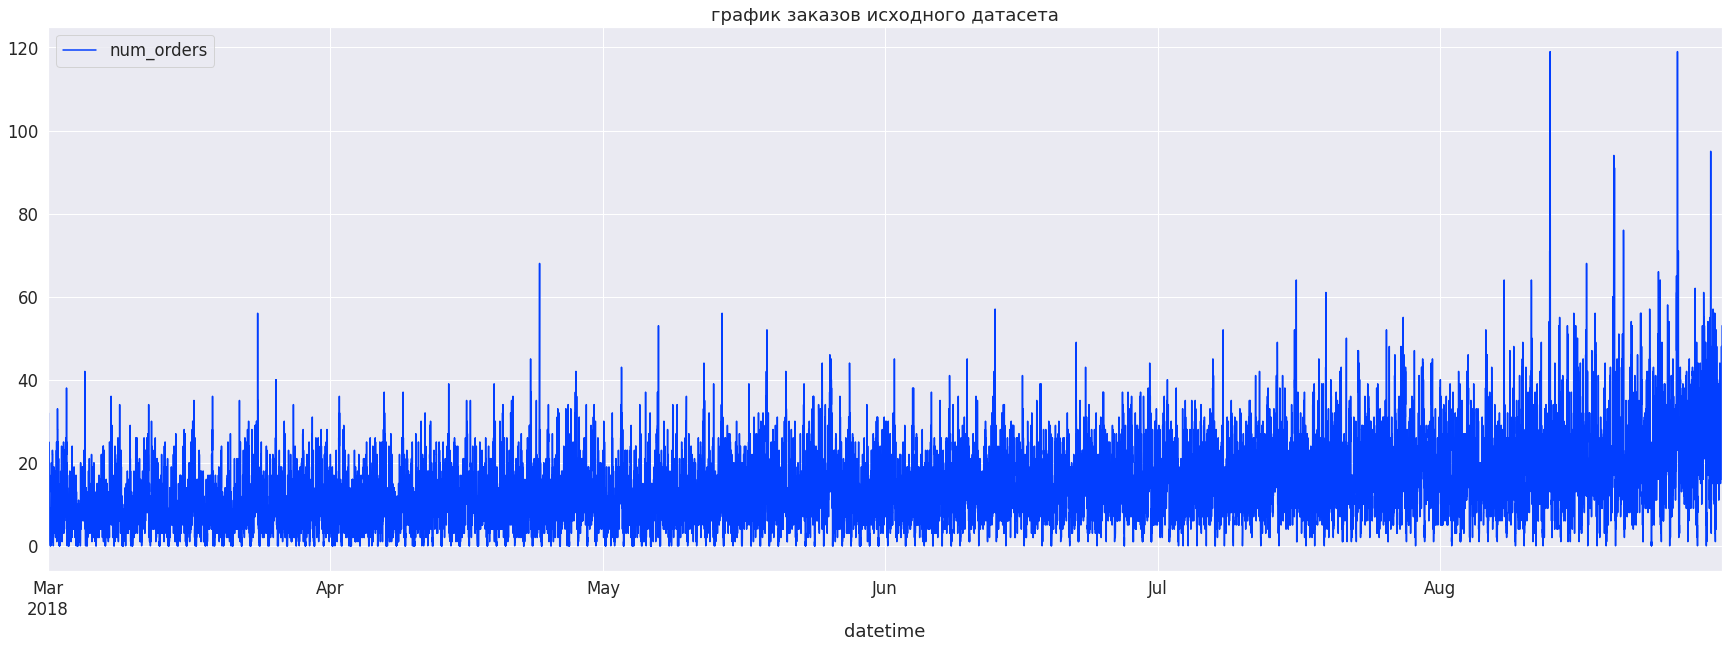

In [8]:
df.plot(figsize = (30,10), title = 'график заказов исходного датасета')

## 2.3 Поскольку надо предсказать заказы за 1 час, делаем ресемплирование

In [9]:
df_1h = df.resample('1H').sum()
df_1h

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


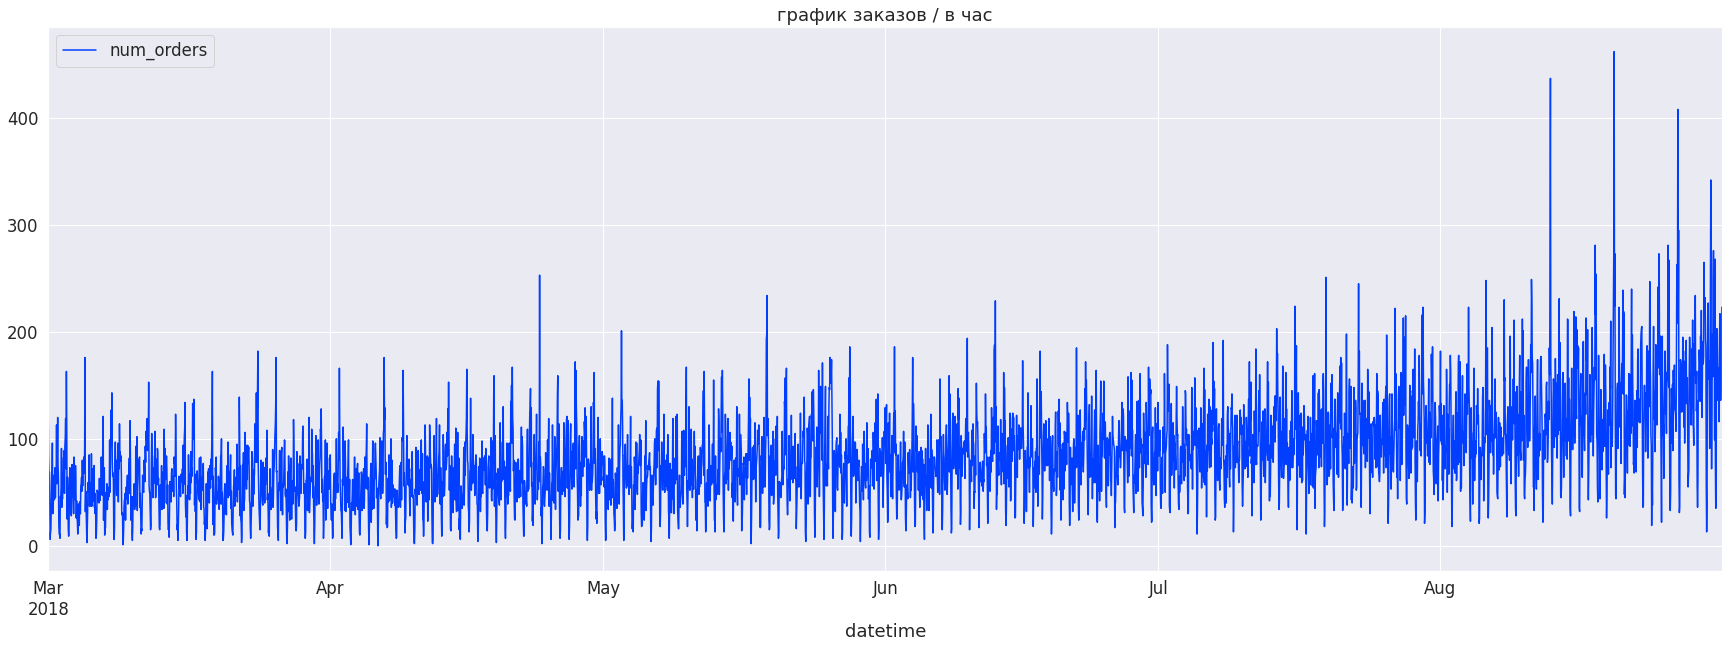

In [10]:
df_1h.plot(figsize = (30,10), title = 'график заказов / в час')

## 2.4 Посмотрим на тренды и сезонность

In [11]:
decomposed = seasonal_decompose(df_1h)

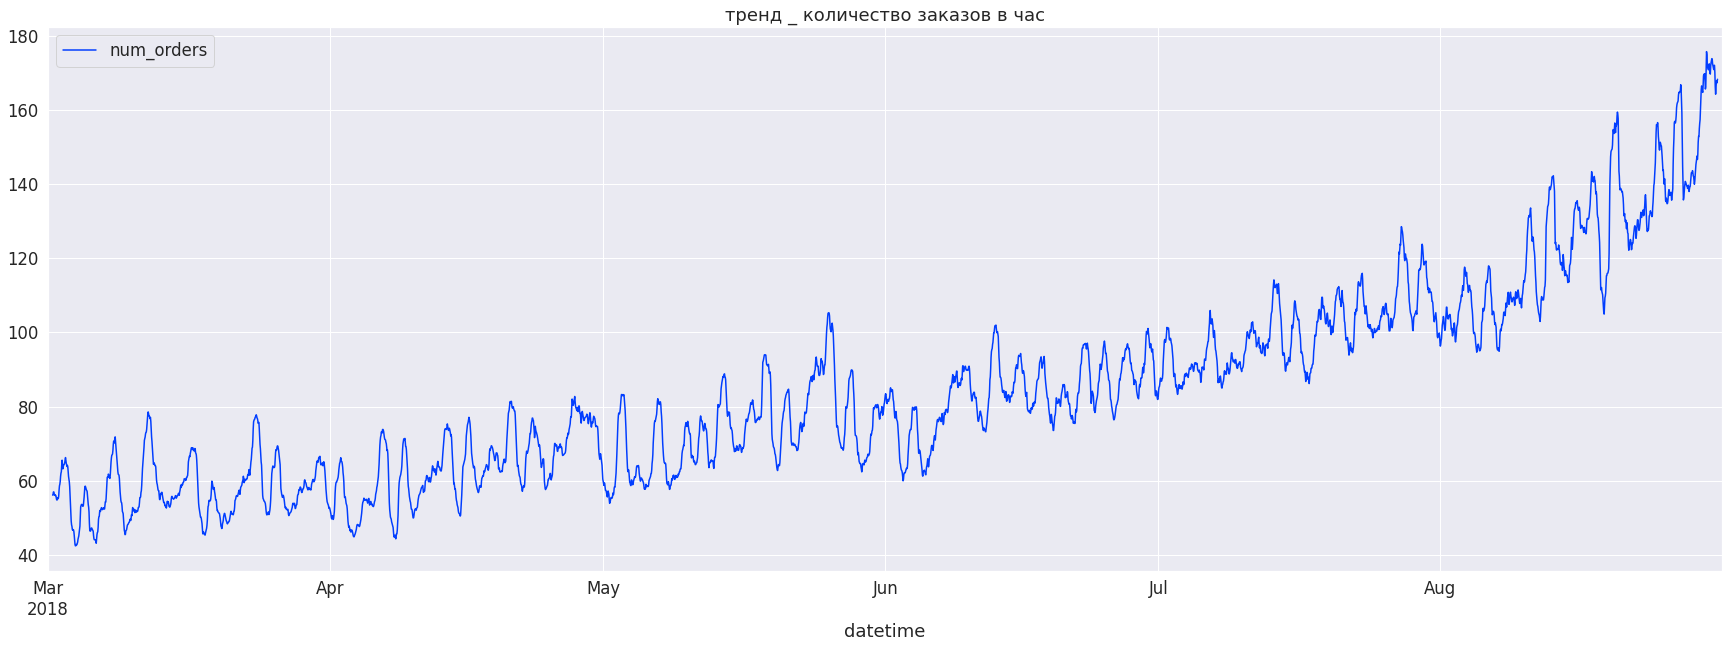

In [12]:
decomposed.trend.plot(figsize = (30,10), title = 'тренд _ количество заказов в час')

По графику тренда видим, что происходит стабильное увеличение числа заказов с каждым месяцем.  
Также посмотрим как ведет себя тренд по неделям, для этого посмотрим тренд в случайно выбранный месяц и сделаем на графике разбивку по неделям  
Для наглядности по горизонтали отложем значение dayofweek и разделим линиями каждую неделю

In [13]:
# задаем интервал, в котором будем строить график
date_1 = pd.to_datetime('2018-03-31')
date_2 = pd.to_datetime('2018-05-01')

# число дней в интервале
delta_days = (date_2 - date_1).days
delta_days

31

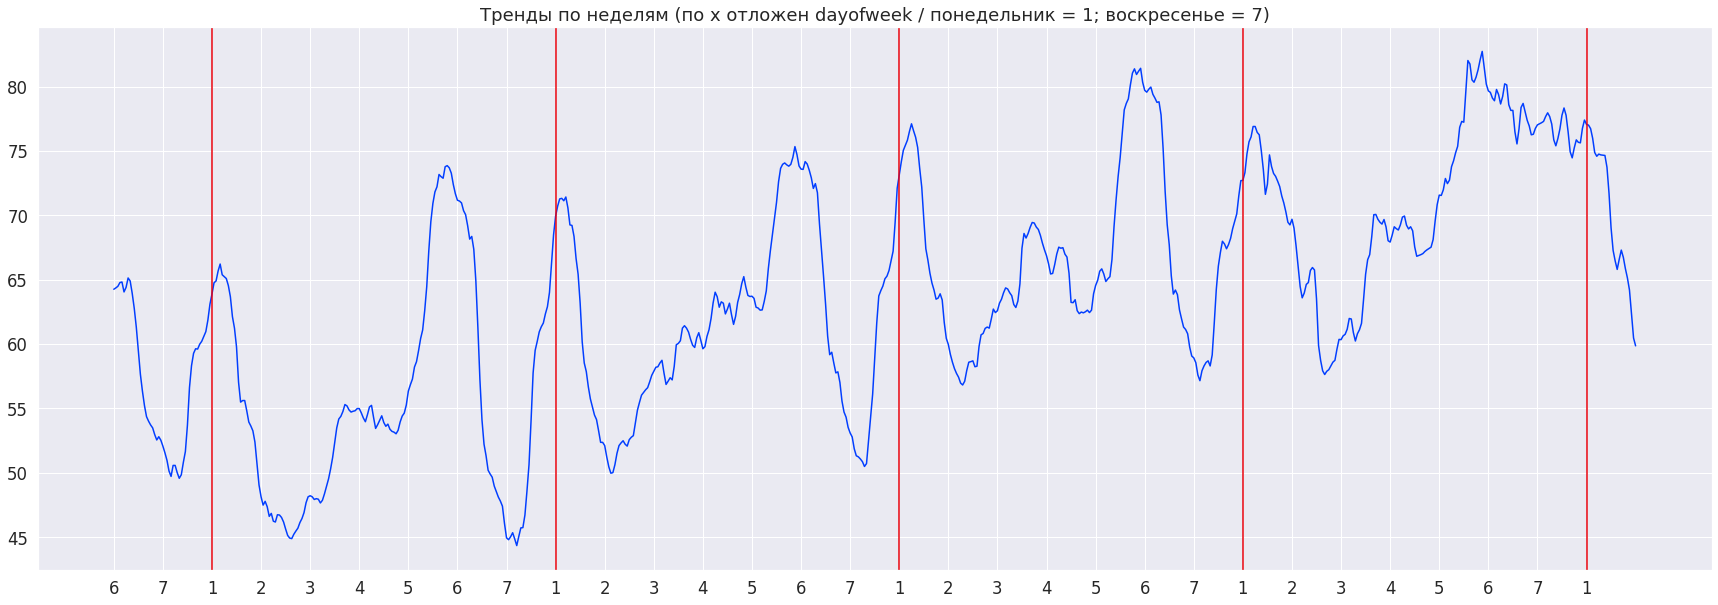

In [14]:
# Вычисляем необходимые параметры для задания меток на оси X:
xt = [(date_1 + pd.to_timedelta(i, unit='d')).date() for i in range(delta_days)]
xt_dayweek = [(date_1 + pd.to_timedelta(i, unit='d')).dayofweek + 1 for i in range(delta_days)]

# строим график

plt.figure(figsize=(30,10))
plt.plot(decomposed.trend[date_1:date_2])
plt.title('Тренды по неделям (по x отложен dayofweek / понедельник = 1; воскресенье = 7)')

plt.xticks(ticks = xt, labels = xt_dayweek) 

plt.axvline(x = pd.to_datetime(['2018-04-02']), color='r')
plt.axvline(x = pd.to_datetime(['2018-04-09']), color='r')
plt.axvline(x = pd.to_datetime(['2018-04-16']), color='r')
plt.axvline(x = pd.to_datetime(['2018-04-23']), color='r')
plt.axvline(x = pd.to_datetime(['2018-04-30']), color='r')
plt.show()

Видим, что в каждую неделю наблюдается определнная закономерность.  Значит есть смысл в качестве признака задать "dayofweek".  
Посмотрим на сезонность

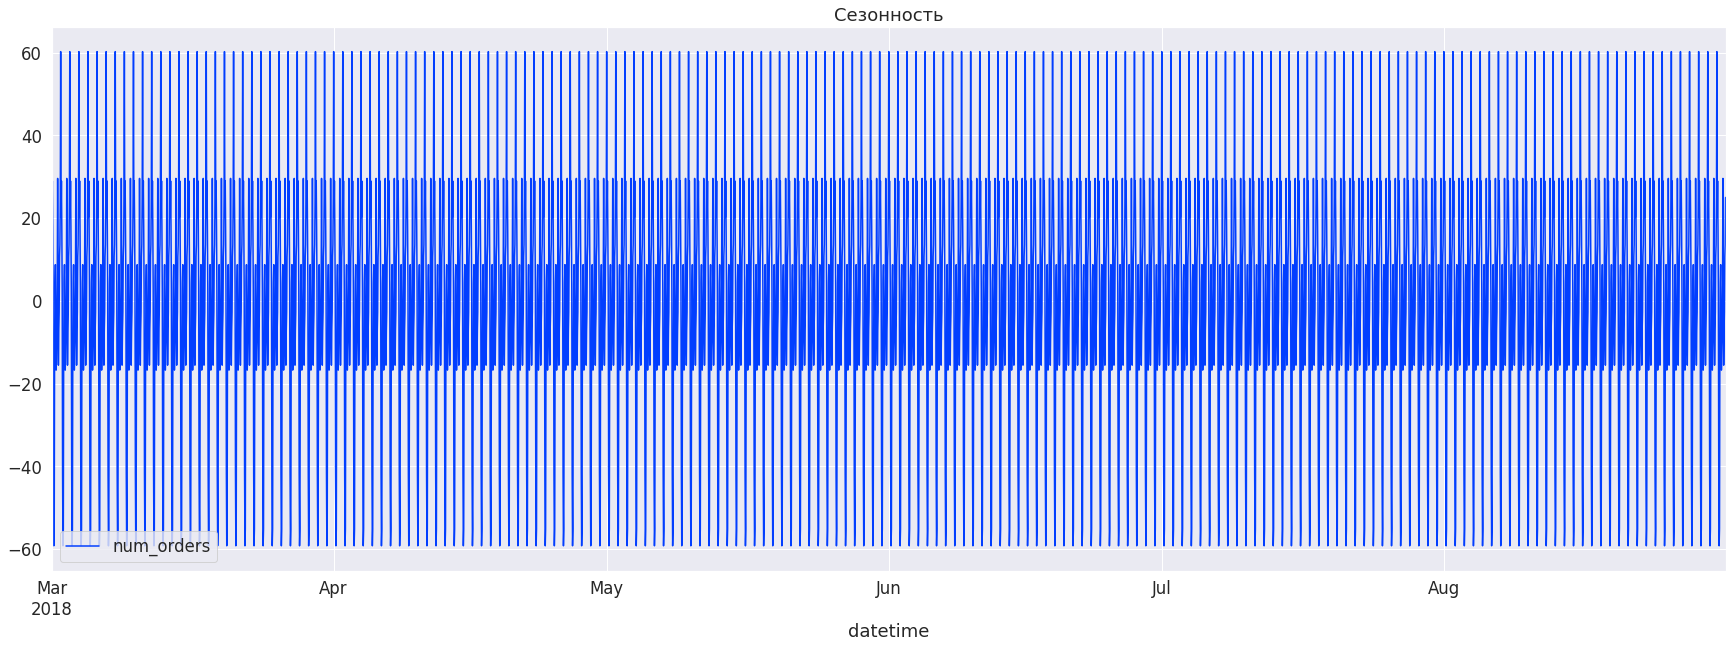

In [15]:
decomposed.seasonal.plot(figsize = (30,10), title = 'Сезонность')

Возьмем меньший интервал, чтобы определить шаг периодичности

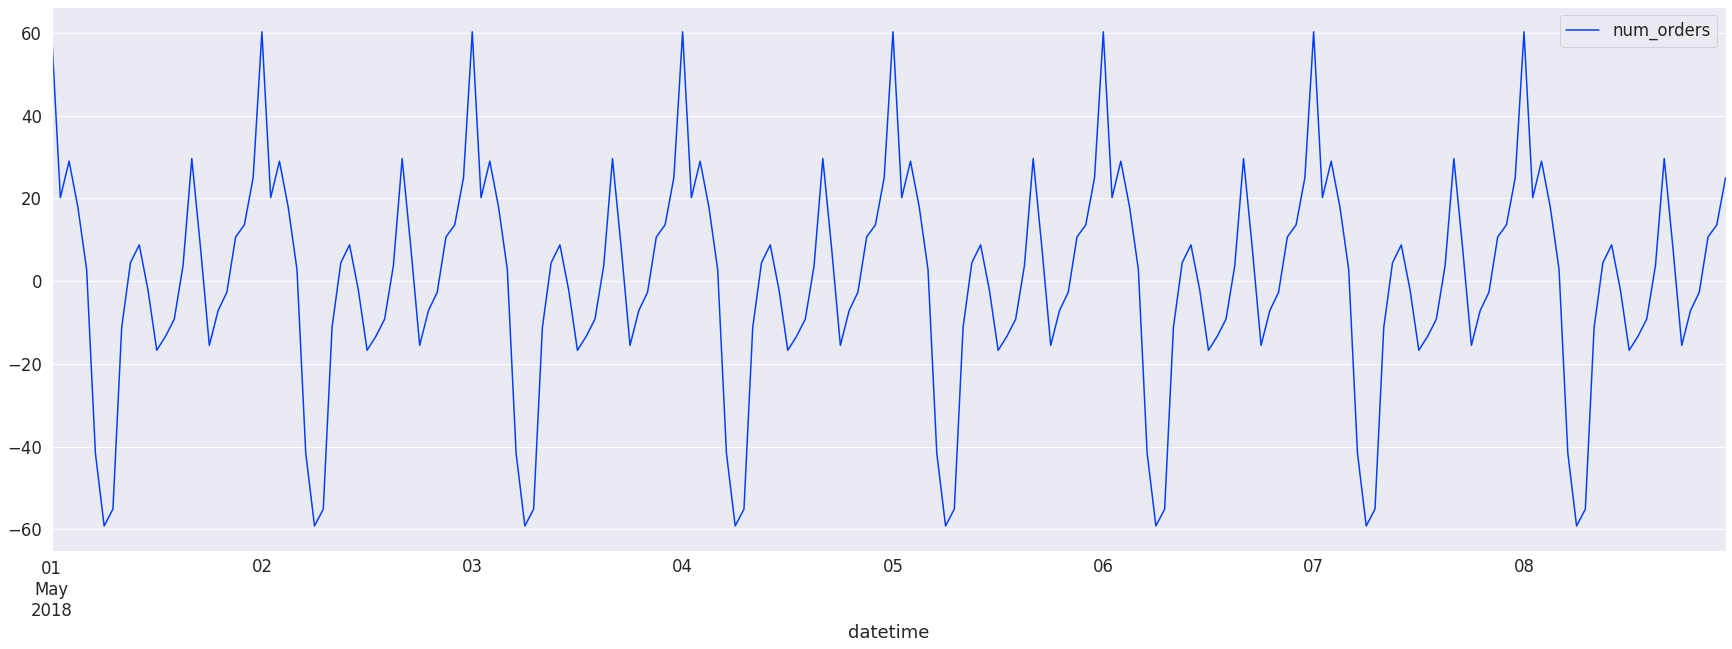

In [16]:
decomposed.seasonal['2018-05-01':'2018-05-08'].plot(figsize = (30,10))

Шаг сезонности равен 1 дню.  
Также посмотрим на график остатка (шум)

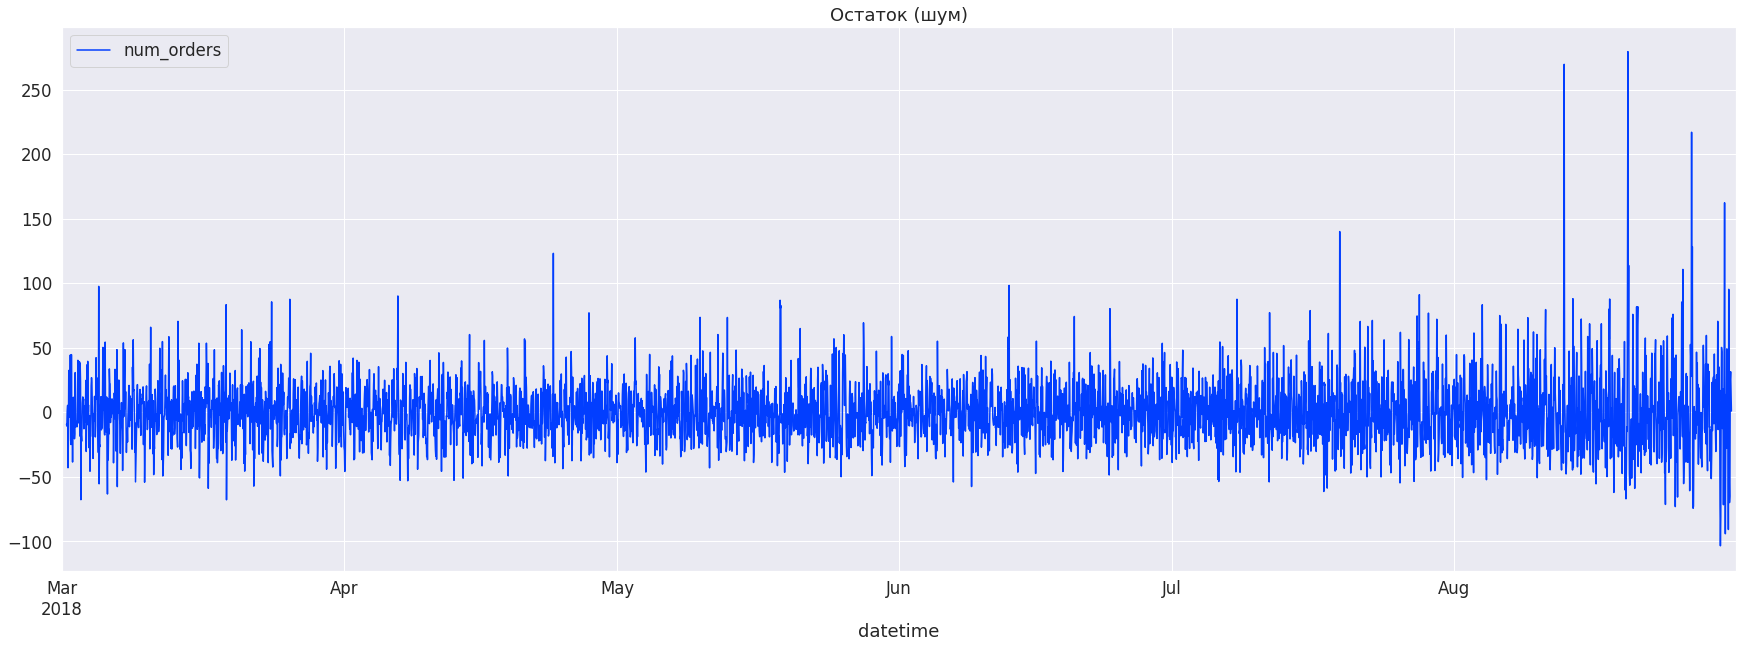

In [17]:
decomposed.resid.plot(figsize=(30,10), title = 'Остаток (шум)')

## 2.5 Создание признаков  
Посмотрим на автокорреляцию чтобы выбрать лаги в качестве признаков.  
ACF (Autocorrelation Function) and PACF (Partial Autocorrelation Function) plots.

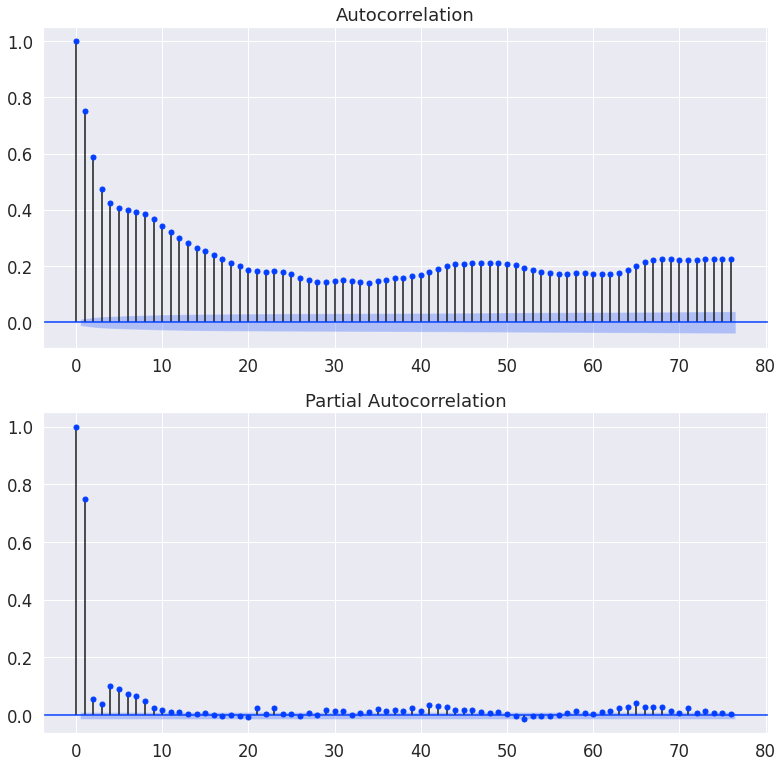

In [18]:
fig , ax = plt.subplots(2,1, figsize = (13,13))
plot_acf(df['num_orders'], lags=76, ax = ax[0])
plot_pacf(df['num_orders'], lags=76, ax = ax[1])
plt.show()

Исходя из графиков ACF и PACF можем выделить следующие лаги

In [19]:
### ACF:
lags_acf = [1,2,3]

### PACF:
lags_pacf = [1]

lags_choosen  = list(set(lags_acf + lags_pacf))
lags_choosen

[1, 2, 3]

Задаем функцию для создания признаков

In [20]:
def make_features(data, lags_choosen, rolling_mean_size):
    # календарные признаки
    # 1) Фактор год: у нас данные меньше чем за 1 год. Нет смысла его задавать, т.к. будет просто константа
    #data['year'] = data.index.year
    
    # 2) Фактор месяц: Детальный коментарий написан выше.  По имеещимся данным имеется тренд: увеличение продаж с каждым месяцем, 
    # но это может оказаться сезонностью по времени года - надо смотреть данные за разные года. В рамках данной задачи (предсказание следующео часа) решаем
    # задать этот признак
    data['month'] = data.index.month  
    
    # 3) Фактор день: закономерность по дням месяца не наблюдается, не будем вводить этот признак
    #data['day'] = data.index.day  
    
    # 4) Фактор день недели: показали выше, что в каждую неделю повторяется определенная закономерность, задаем этот признак
    data['dayofweek'] = data.index.dayofweek  
    
    # 5) Фактор час:  выше обнаружили сезонность по дням.  Т.е. в каждый день повторяется определенная закономерность, задаем этот признак
    data['hour'] = data.index.hour
    
    # скользящее среднее
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()   
      
   # Отстающие значения c учетом ACF PACF:
    for lag in lags_choosen:
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)    
    
    # удаляем пропуски
    df_1h.dropna(inplace=True) 

In [21]:
make_features(df_1h, lags_choosen, 6)
df_1h

,num_orders,month,dayofweek,hour,rolling_mean,lag_1,lag_2,lag_3
datetime,,,,,,,,
2018-03-01 06:00:00,12,3,3,6,65.833333,6.0,43.0,66.0
2018-03-01 07:00:00,15,3,3,7,47.166667,12.0,6.0,43.0
2018-03-01 08:00:00,34,3,3,8,35.500000,15.0,12.0,6.0
2018-03-01 09:00:00,69,3,3,9,29.333333,34.0,15.0,12.0
2018-03-01 10:00:00,64,3,3,10,29.833333,69.0,34.0,15.0
...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,8,4,19,172.666667,207.0,217.0,197.0
2018-08-31 20:00:00,154,8,4,20,167.666667,136.0,207.0,217.0
2018-08-31 21:00:00,159,8,4,21,171.166667,154.0,136.0,207.0


## 2.6 Предобработка признаков  
Последовательность предобработки:
1. Отделение целевого признака от остальных.
2. Обработка категориальных признаков.  (делается перед разделением на train и test, т.к. в общем случае нам может быть нужно onehot-преобразование и у нас может быть категориальный признак с сотнями значений и нужно чтобы все варианты признаков попали и в test и в train) 
3. Разделение на обучающую и тестовую выборки (потому что это надо делать перед нормализацией)  
4. Нормализация числовых признаках (обучаемся только на train выборке, а преобразование делаем и на train и на test)

### 2.6.1 Отделение целевого признака от остальных.

In [22]:
X = df_1h.drop('num_orders', axis = 1)
y = df_1h['num_orders']

### 2.6.2 Обработка категориальных признаков.  
Единственный категориальный признак - dayofweek. Он уже имеет вид ordinalencoding.  Преобразование не требуется

### 2.6.3 Разделение на обучающую и тестовую выборки

In [23]:
aa = np.arange(100)
tscv = TimeSeriesSplit(n_splits=2)

for train_index, test_index in tscv.split(aa):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = aa[train_index], aa[test_index]
    #y_train, y_test = y[train_index], y[test_index]

TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33] TEST: [34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57
 58 59 60 61 62 63 64 65 66]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66] TEST: [67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90
 91 92 93 94 95 96 97 98 99]


In [24]:
X_train, X_test, y_train, y_test =  train_test_split(X,y, shuffle=False, test_size=0.1, random_state = 42)

### 2.6.4 Нормализация числовых признаках 

In [25]:
num_features = X.columns.drop(['dayofweek', 'hour'])
num_features

Index(['month', 'rolling_mean', 'lag_1', 'lag_2', 'lag_3'], dtype='object')

In [26]:
scaler = StandardScaler()
scaler.fit(X_train[num_features])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [27]:
X_train[num_features] = scaler.transform(X_train[num_features])
X_test[num_features] = scaler.transform(X_test[num_features])

display(X_train[num_features].head(2))
display(X_test[num_features].head(2))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1736: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

,month,rolling_mean,lag_1,lag_2,lag_3
datetime,,,,,
2018-03-01 06:00:00,-1.414612,-0.466422,-1.868975,-0.911936,-0.317119
2018-03-01 07:00:00,-1.414612,-1.167325,-1.713855,-1.868545,-0.911769


,month,rolling_mean,lag_1,lag_2,lag_3
datetime,,,,,
2018-08-13 15:00:00,1.754254,1.755190,0.612952,1.052991,0.355096
2018-08-13 16:00:00,1.754254,1.992996,2.500250,0.613468,1.053164


# 3. Подбор модели машинного обучения

Задаем функцию rmse в качестве метрики

In [28]:
def RMSE(y_actual, y_predict):
    return np.sqrt(MSE(y_actual, y_predict))

my_scorer = make_scorer(RMSE, greater_is_better=False)

Задаем разбиение на подвыборки без перемешивания (необходиом для временных рядов)

In [29]:
my_cv = [(train,test) for train, test in TimeSeriesSplit(n_splits=5).split(X_train)]

## 3.1 Константная модель 

In [30]:
y_predict_const = np.ones( y_test.shape) * y_train.median()

In [31]:
rmse_const_train_best = RMSE(y_test,y_predict_const)
rmse_const_train_best

87.24205906985632

## 3.2 Предыдущее значение

In [32]:
y_predict_prev = y_test.shift()
y_predict_prev.iloc[0] = y_train.iloc[-1]

In [33]:
rmse_prev_train_best = RMSE(y_test,y_predict_prev)
rmse_prev_train_best

58.91761802963282

## 3.3 Линейная регрессия  
У линейной регрессии нет гиперпараметров, но обучаем ее через GridSearchCV чтобы сохранить единообразие вычислений с другими моделями

In [34]:
# Задаем гиперпараметры для подбора
param_grid_LR = {'n_jobs':[-1]}

# Задаем модель
model_LR = GridSearchCV(
    estimator= LinearRegression(n_jobs=-1),
    param_grid = param_grid_LR, cv = my_cv, n_jobs=-1 , scoring = my_scorer)

# Обучаем модель и вычисляем время на обучение
start_time = timeit.default_timer()
model_LR.fit(X_train,y_train) 
fit_time_LR = round(timeit.default_timer() - start_time, 1)
print('время обучения: {} сек'.format(fit_time_LR))


время обучения: 1.5 сек


Лучшие параметры

In [35]:
model_LR.best_params_

{'n_jobs': -1}

RMSE на обучающей выборке

In [36]:
rmse_LR_train_best = abs(model_LR.best_score_)
rmse_LR_train_best

31.634239344346064

## 2.3 Модель случайный лес

In [37]:
# Задаем гиперпараметры для подбора
param_grid_RF = {'n_estimators': [50, 100, 200],
                'max_depth': [20 ,22, 25, 28],
                'min_samples_split' : [8 ,10, 12, 14],
                 'min_samples_leaf': [2, 3, 4]}
# Сразу подставляем уже найденные лучшие параметры:
param_grid_RF = {'n_estimators': [200],
                'max_depth': [22],
                'min_samples_split' : [12],
                 'min_samples_leaf': [3]}


# Задаем модель  
model_RF = GridSearchCV(
    estimator = RandomForestRegressor(n_jobs=-1, random_state=42), 
    param_grid= param_grid_RF, scoring = my_scorer, cv = my_cv, verbose=1, n_jobs= -1)        

 # Обучаем модель и вычисляем время на обучение
start_time = timeit.default_timer()
model_RF.fit(X_train,y_train)
fit_time_RF = round(timeit.default_timer() - start_time, 1)
print('время обучения: {} сек'.format(fit_time_RF))      

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.9s finished


время обучения: 6.7 сек


In [38]:
model_RF.best_params_

{'max_depth': 22,
 'min_samples_leaf': 3,
 'min_samples_split': 12,
 'n_estimators': 200}

In [39]:
rmse_RF_train_best = abs(model_RF.best_score_)
rmse_RF_train_best

24.96217136722637

### 3.5 Модель LightGBM

Признак dayofweek и hour задаем в качестве категориальных, т.к.  есть зависимость от конкретного его значения, а не от "модуля" этого значения

In [40]:
cat_features = ['dayofweek', 'hour']

In [41]:
# Задаем гиперпараметры для подбора
param_grid_LGBM = {'max_depth': [6, 8, 10, 12, 14, 17, 20, 23],
                  'min_data_in_leaf': [4, 6, 8, 10, 14, 17, 20, 25, 35, 40],
                  'n_estimators' : [100, 200],
                  'num_leaves': [30, 50, 70, 100, 150, 200]}
# сразу подставляем лушие параметры
param_grid_LGBM = {'max_depth': [14, 15, 16],
                  'min_data_in_leaf': [10],
                  'n_estimators' : [200],
                  'num_leaves': [70]}

 # Задаем модель   
model_LGBM = GridSearchCV(
    estimator = LGBMRegressor(random_state =42, n_jobs=-1), 
    param_grid= param_grid_LGBM, cv = my_cv, verbose=1, n_jobs=-1, scoring = my_scorer)

# Обучаем модель и вычисляем время на обучение
start_time = timeit.default_timer()
model_LGBM.fit(X_train, y_train, categorical_feature=list(cat_features))
fit_time_LGBM = round(timeit.default_timer() - start_time, 1)
print('время обучения: {} сек'.format(fit_time_LGBM))                 

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    3.5s finished
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['dayofweek', 'hour']



время обучения: 4.0 сек


In [42]:
model_LGBM.best_params_

{'max_depth': 15,
 'min_data_in_leaf': 10,
 'n_estimators': 200,
 'num_leaves': 70}

In [43]:
rmse_LGBM_train_best = abs(model_LGBM.best_score_)
rmse_LGBM_train_best

25.70583459561761

## 3.5 Модель Catboost

In [44]:
# Задаем гиперпараметры для подбора
param_grid_Cat = {'iterations': [100, 200],
                'depth': [4, 6, 8, 10, 12]}
# сразу подставляем найденные лушие параметры
param_grid_Cat = {'iterations': [200],
                'depth': [4]}


 # Задаем модель
model_Cat = GridSearchCV(
    estimator = CatBoostRegressor(random_state = 42, verbose=None),
    param_grid= param_grid_Cat, cv = my_cv, verbose=10, n_jobs=-1, scoring = my_scorer)


 # Обучаем модель и вычисляем время на обучение    
start_time = timeit.default_timer()
model_Cat.fit(X_train, y_train, cat_features = list(cat_features))
fit_time_Cat = round(timeit.default_timer() - start_time, 1)
print('время обучения: {} сек'.format(fit_time_Cat))            

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    2.2s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.8s finished


Learning rate set to 0.169505
0:	learn: 35.9140597	total: 50.9ms	remaining: 10.1s
1:	learn: 33.6107138	total: 53.5ms	remaining: 5.3s
2:	learn: 31.5972274	total: 55.7ms	remaining: 3.65s
3:	learn: 30.1633277	total: 57.8ms	remaining: 2.83s
4:	learn: 28.8969337	total: 60.1ms	remaining: 2.35s
5:	learn: 27.8983488	total: 62.3ms	remaining: 2.01s
6:	learn: 27.1563492	total: 64.8ms	remaining: 1.79s
7:	learn: 26.5541772	total: 67ms	remaining: 1.61s
8:	learn: 26.0147528	total: 69.3ms	remaining: 1.47s
9:	learn: 25.6312454	total: 71.1ms	remaining: 1.35s
10:	learn: 25.3026457	total: 73.4ms	remaining: 1.26s
11:	learn: 25.0329802	total: 75.4ms	remaining: 1.18s
12:	learn: 24.7857714	total: 77.6ms	remaining: 1.11s
13:	learn: 24.6627477	total: 79.7ms	remaining: 1.06s
14:	learn: 24.4627325	total: 82.7ms	remaining: 1.02s
15:	learn: 24.3288737	total: 84.9ms	remaining: 977ms
16:	learn: 24.3060821	total: 86.7ms	remaining: 933ms
17:	learn: 24.1783810	total: 88.8ms	remaining: 898ms
18:	learn: 24.1111503	total: 

In [45]:
model_Cat.best_params_

{'depth': 4, 'iterations': 200}

In [46]:
rmse_Cat_train_best = abs(model_Cat.best_score_)
rmse_Cat_train_best

25.344774299864916

## 3.6 Анализ результатов
Объединим результаты в таблицу

In [47]:
models_analysis = pd.DataFrame({
    'fit_time_with_best_params':[0, 0, fit_time_LR, fit_time_RF, fit_time_LGBM, fit_time_Cat],
    'train_RMSE_score':[rmse_const_train_best, rmse_prev_train_best, rmse_LR_train_best, rmse_RF_train_best, rmse_LGBM_train_best, rmse_Cat_train_best],
    },
    index = ['const', 'previously', 'lin_reg', 'random_forrest(n_estim=200)', 'LGBM_(n_estim=200)', 'cat_boost_(iterations=200)'])
                                            
models_analysis.sort_values('train_RMSE_score', inplace=True)
models_analysis

,fit_time_with_best_params,train_RMSE_score
random_forrest(n_estim=200),6.7,24.962171
cat_boost_(iterations=200),3.4,25.344774
LGBM_(n_estim=200),4.0,25.705835
lin_reg,1.5,31.634239
previously,0.0,58.917618
const,0.0,87.242059


Лучший результат на обучающей выборке у random_forrest, дальше проводим тестирование на ней

# 4. Тестирование

In [48]:
model_best = model_RF.best_estimator_

In [49]:
rmse_best_test = RMSE(y_test, model_Cat.predict(X_test))
rmse_best_test

44.31136082768801

Лучшая модель random_forrest показала на тесте rmse < максимально допустимого значения '48'.

# 5. Дополнительное иследование. Поиск оптимального количества  lag-ов  оптимального размера окна для скользящего среднего 

На данный момент нет идей, по которым можно предположить оптимальное значение этих параметров для улучшения модели.  Но есть интуитивное предположение:  
- у нас сезонность = 1 день; мы изучаем значения за 1 час; в 1 дне 24 часа.  Тогда кажется логично взять количество лагов = 24 чтобы охватить один период сезонности. Лаги за пределами 1 периода будут "дублировать" лаги этого же периода.   Чтобы в этом убедиться возьмем лаги за 2 периода = 2 дня = т.е. у нас будет 48 лагов (48 часов в 2 днях).  
По поводу окна скользящего среднего нет идей и предположений, поэтому просто переберем этот параметр по аналогии с лагами - от 1 до 48.  


Ниже в цикле проиходит обучение модели (выбрали LGBM (n_estimators = 100) из-за ее скорости) 48х48 раз,  и значение rmse заносится в матрицу array_of_scores, у которой номер строки = число лагов / номер столбца = размеру окна.   Вычисления очнь долгие, поэтому код закоментирован, а результаты уже сохранены и импортируются из внешнего файла

In [50]:
# param_grid_LGBM = {'max_depth': [14],
#                   'min_data_in_leaf': [10],
#                   'n_estimators' : [100],
#                   'num_leaves': [70]}

# model_LGBM_search = GridSearchCV(estimator = LGBMRegressor(random_state=42, n_jobs=-1), 
#              param_grid= param_grid_LGBM, cv=3, verbose=1, n_jobs=-1, scoring = my_scorer)

# i_num = 48
# j_num = 48
# array_of_scores = np.ones([i_num, j_num])

# # i - количество lag-ов
# for i in range(1, i_num + 1):
#     # j - rolling_mean_size
#     for j in range(1, j_num + 1):
#         df_1h_search = df_1h['num_orders'].to_frame()
#         make_features(df_1h_search, i, j)
#         print('i = {}; j = {}'.format(i,j))
#         df_1h_search.dropna(inplace=True)
        
#         X = df_1h_search.drop('num_orders', axis = 1)
#         y = df_1h_search['num_orders']
        
#         X_train, X_test, y_train, y_test =  train_test_split(X,y, shuffle=False, test_size=0.1, random_state = 42)
        
#         model_LGBM_search.fit(X_train, y_train)
        
#         array_of_scores[i-1,j-1] = model_LGBM_search.best_score_

Импортируем результаты из внешнего файла

In [51]:
spreadsheet_id = "1kmLQfmNsq9RCjzc_c_zRcywqTRJ98BI1"
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=xlsx'.format(spreadsheet_id)
r = requests.get(file_name)
df_ij = pd.read_excel(BytesIO(r.content), index_col = [0])
df_ij

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47
0,-27.540951,-26.809221,-26.561996,-26.480685,-26.228867,-26.008142,-25.990199,-25.678784,-26.129390,-26.038966,-25.994265,-25.852780,-25.362329,-25.490690,-25.500993,-25.704881,-25.968539,-25.935927,-26.219120,-26.608328,-26.795356,-26.681065,-26.841657,-26.601284,-26.352152,-26.344282,-26.866441,-26.728258,-26.216096,-25.838518,-26.012190,-26.173905,-26.352376,-26.784967,-26.634998,-25.913454,-26.222440,-26.300868,-26.695517,-26.621771,-26.603979,-26.516703,-26.619755,-26.284402,-27.400656,-26.863764,-25.535224,-26.231808
1,-26.594489,-26.404648,-26.266784,-26.207306,-25.983284,-26.059760,-25.272895,-25.346866,-25.936518,-25.924986,-26.030574,-26.013218,-25.501287,-25.169442,-25.213735,-25.801419,-25.744470,-25.627762,-26.065937,-25.824725,-26.015115,-26.417935,-26.066121,-26.331649,-25.826528,-26.002449,-26.122076,-26.102691,-26.229949,-26.115913,-25.873533,-25.955822,-26.722972,-26.601362,-26.775741,-26.236148,-26.184294,-26.311199,-26.506014,-26.988343,-26.675626,-26.379194,-26.327976,-26.559549,-27.100698,-26.717395,-26.266584,-26.572432
2,-26.499757,-26.348134,-26.667140,-26.418355,-26.189674,-25.999432,-25.631551,-25.537830,-25.680716,-25.781463,-25.863272,-26.057833,-25.809861,-25.612946,-25.364969,-25.646935,-25.736091,-25.881327,-25.943873,-25.994783,-26.378899,-26.534438,-26.167924,-26.418009,-26.332825,-26.233339,-26.071671,-26.141284,-26.053571,-25.837890,-25.922948,-25.898454,-26.652956,-26.016010,-26.344821,-26.347984,-26.458012,-26.954900,-26.656923,-26.700340,-26.923232,-26.994808,-26.677616,-26.403520,-27.268250,-27.137118,-26.336153,-26.899854
3,-26.267590,-26.099922,-26.458839,-26.346344,-26.170147,-26.077768,-25.631051,-25.536987,-25.967580,-25.823883,-26.168541,-25.915867,-25.607055,-25.519889,-25.499866,-25.639161,-25.560464,-25.740032,-25.865054,-25.934174,-26.121752,-26.181419,-26.204503,-26.047065,-26.108487,-26.381979,-26.300959,-26.120798,-25.705628,-25.750792,-25.703754,-26.096500,-26.610149,-26.204481,-26.238275,-26.230218,-26.362758,-26.543673,-26.554882,-26.326413,-26.572588,-26.479296,-26.304899,-26.404157,-26.496497,-26.443640,-26.007803,-26.525343
4,-25.986260,-25.977356,-26.116048,-26.181663,-26.109919,-26.009780,-26.004394,-25.510924,-25.960044,-25.970184,-26.030733,-25.782480,-25.791996,-25.723068,-25.294902,-25.878420,-25.585949,-25.825908,-25.725287,-25.942579,-25.885893,-26.176077,-26.147030,-25.998907,-26.180172,-26.318160,-25.863456,-25.987965,-25.803198,-25.808835,-25.861005,-25.947569,-26.135627,-26.160039,-26.198725,-26.102878,-26.206121,-26.609163,-26.226200,-26.164547,-26.335443,-26.246440,-26.143286,-26.320592,-26.575940,-26.239749,-25.792200,-26.237348
5,-25.837854,-26.019555,-26.366606,-26.089779,-26.242803,-26.442106,-26.119614,-25.977997,-26.267554,-26.214802,-25.802514,-25.855182,-25.746304,-25.584019,-25.581401,-25.587215,-25.785986,-25.737954,-25.648379,-26.103288,-25.936650,-26.141198,-26.180686,-25.749823,-25.947609,-26.099320,-25.907584,-26.126432,-25.978142,-26.172551,-25.934943,-26.122649,-26.233581,-26.338066,-25.942518,-26.067589,-26.185670,-26.126200,-26.611214,-26.315816,-26.461369,-26.398052,-26.360508,-26.405682,-26.475200,-26.635374,-25.938458,-26.142154
6,-25.577737,-25.497017,-25.551958,-25.720258,-25.798106,-25.658486,-25.578294,-25.399857,-25.847222,-25.554324,-25.523402,-25.586025,-25.413941,-25.381364,-25.550290,-25.521153,-25.369817,-25.473080,-25.526211,-25.631836,-25.632865,-25.814013,-25.728282,-25.432591,-25.709498,-25.530343,-25.766160,-25.566628,-25.705012,-25.774917,-25.807165,-25.801271,-25.979507,-26.276638,-26.042262,-26.250217,-26.058998,-26.349586,-26.250672,-26.048135,-26.252690,-25.875329,-25.965130,-26.379373,-26.123020,-26.335567,-25.863903,-25.796408
7,-25.717059,-25.495286,-25.746994,-25.747333,-25.900857,-25.519436,-25.769575,-25.553513,-25.788509,-25.696173,-25.694518,-25.681724,-25.375080,-25.291717

Покажем результат на тепловой карте

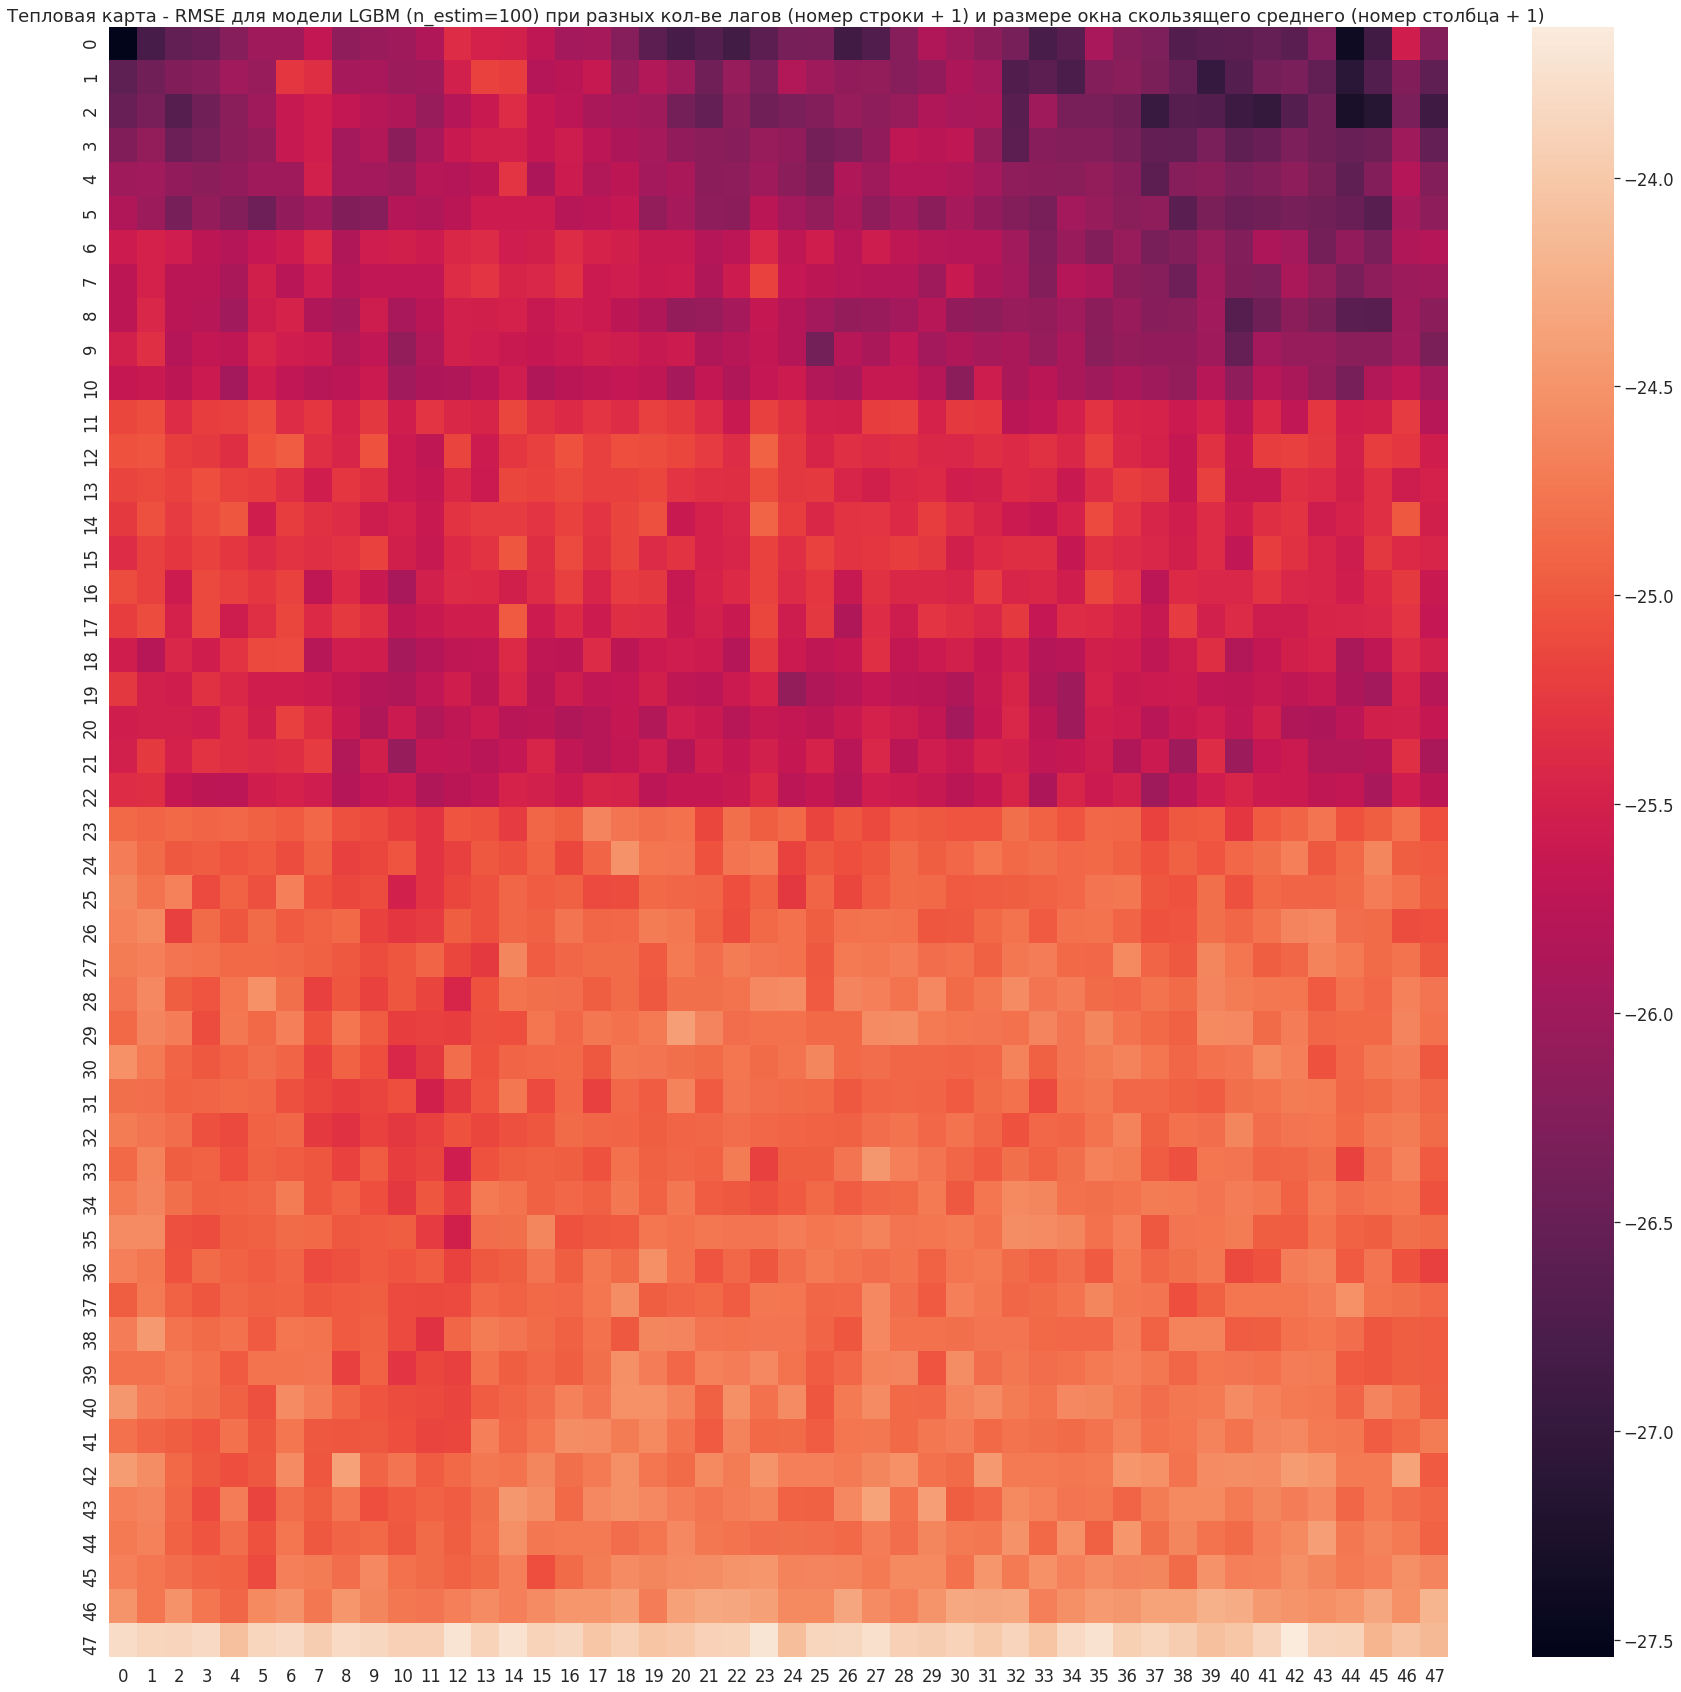

In [52]:
plt.figure(figsize=(30,30))
plt.title('Тепловая карта - RMSE для модели LGBM (n_estim=100) при разных кол-ве лагов (номер строки + 1) и размере окна скользящего среднего (номер столбца + 1) ')
fig = sns.heatmap(df_ij)

Видим, что при увеличении лагов качество повышается, а вот от размера окна зависимости нет.  
Посмотрим на среднее значание RMSE по столбцам, т.е. посмотрим на влияние именно со стороны размера окна.  
Строим график:

Text(0.5, 1.0, 'Среднее значение RMSE в зависимости от размера окна скользящего среднего')

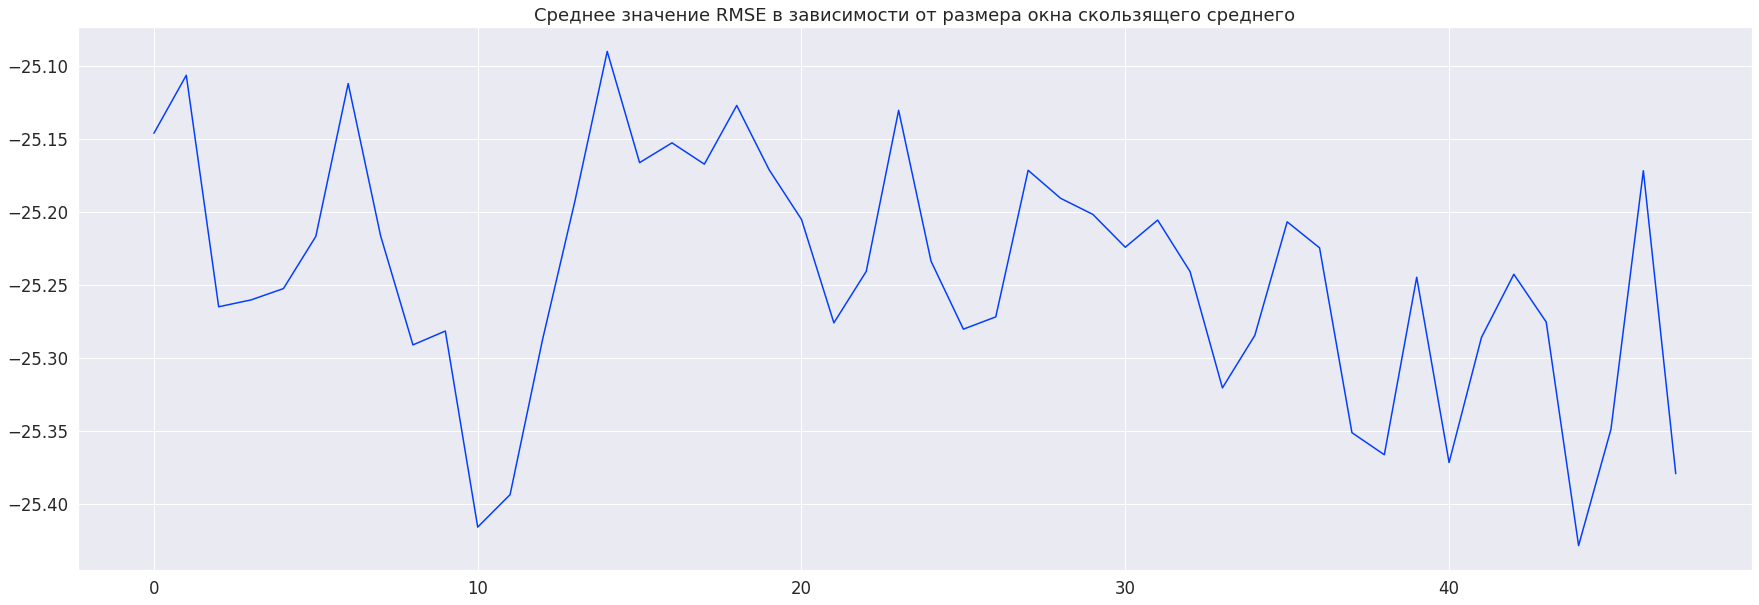

In [53]:
df_ij.mean().plot(figsize = (30,10))
plt.title('Среднее значение RMSE в зависимости от размера окна скользящего среднего')

Можем выделить размер окна при лучшем RMSE.  Но тем не менее график больше похож на шум, т.е. размер окна и возможно само скользящее среднее не влияет на нашу модель

In [54]:
df_ij.mean().idxmax()

14

Поскольку не удалось достичь максимума RMSE при переборе лагов от 1 до 48 -   попробуем перебор с большим шагом = 8.    (С таким же шагом будем перебирать размер окна, возможно увидим какую-то законмерность).
Код очень длинный, поэтому закоментирован. Результаты посчитаны и берутся с внешнего файла

In [55]:
# param_grid_LGBM = {'max_depth': [14],
#                   'min_data_in_leaf': [10],
#                   'n_estimators' : [100],
#                   'num_leaves': [70]}

# model_LGBM_search = GridSearchCV(estimator = LGBMRegressor(random_state=42, n_jobs=-1), 
#              param_grid= param_grid_LGBM, cv=3, verbose=1, n_jobs=-1, scoring = my_scorer)

# i_num = 10
# j_num = 10
# array_of_scores_2 = np.ones([i_num, j_num])

# # i - количество lag-ов
# for i in range(1, i_num + 1):
#     # j - rolling_mean_size
#     for j in range(1, j_num + 1):
#         df_1h_search = df_1h['num_orders'].to_frame()
#         make_features(df_1h_search, i * 8, j * 8)
#         print('i = {}; j = {}'.format(i,j))
#         df_1h_search.dropna(inplace=True)
        
#         X = df_1h_search.drop('num_orders', axis = 1)
#         y = df_1h_search['num_orders']
        
#         X_train, X_test, y_train, y_test =  train_test_split(X,y, shuffle=False, test_size=0.1, random_state = 42)
        
#         model_LGBM_search.fit(X_train, y_train)
        
#         array_of_scores_2[i-1,j-1] = model_LGBM_search.best_score_

In [56]:
#pd.DataFrame(array_of_scores_2).to_excel('file_2.xlsx')

In [57]:
spreadsheet_id = "1G7rUmsFkATxZlny7ZRYYr2VpIV0gVEom"
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=xlsx'.format(spreadsheet_id)
r = requests.get(file_name)
df_ij_2 = pd.read_excel(BytesIO(r.content), index_col = [0])
df_ij_2

,0,1,2,3,4,5,6,7,8,9
0,-25.553513,-25.426834,-25.172084,-25.877024,-25.998946,-26.008593,-25.751569,-26.019151,-26.364853,-25.593484
1,-25.341385,-25.360470,-25.165738,-25.402933,-25.362158,-25.441619,-25.333119,-25.466712,-25.335343,-25.080022
2,-24.885257,-24.901687,-24.959650,-25.031849,-24.981464,-25.080187,-24.598124,-25.026773,-25.095598,-24.988755
3,-25.142016,-25.102725,-24.840205,-24.845469,-24.976628,-24.902583,-24.773522,-24.942990,-25.184914,-24.782078
4,-24.779284,-24.886372,-24.605243,-24.835397,-24.765734,-24.967204,-24.679275,-25.160421,-25.069791,-24.916052
5,-23.952709,-23.885375,-23.713664,-23.984158,-24.086335,-24.155366,-23.721343,-23.924037,-24.086110,-24.014412
6,-23.912208,-23.641687,-23.877353,-23.851051,-23.874466,-23.882615,-23.839577,-23.860677,-23.923079,-23.867445
7,-24.064543,-23.906248,-23.695647,-23.845111,-23.768751,-23.828289,-23.763430,-23.921001,-23.894871,-23.762945
8,-23.701519,-23.643962,-23.685541,-23.331492,-23.499824,-23.687544,-23.447379,-23.658562,-23.556183,-23.709089
9,-23.521556,-23.677847,-23.452637,-23.719235,-23.388124,-23.759086,-23.440400,-23.530142,-23.764841,-23.727892


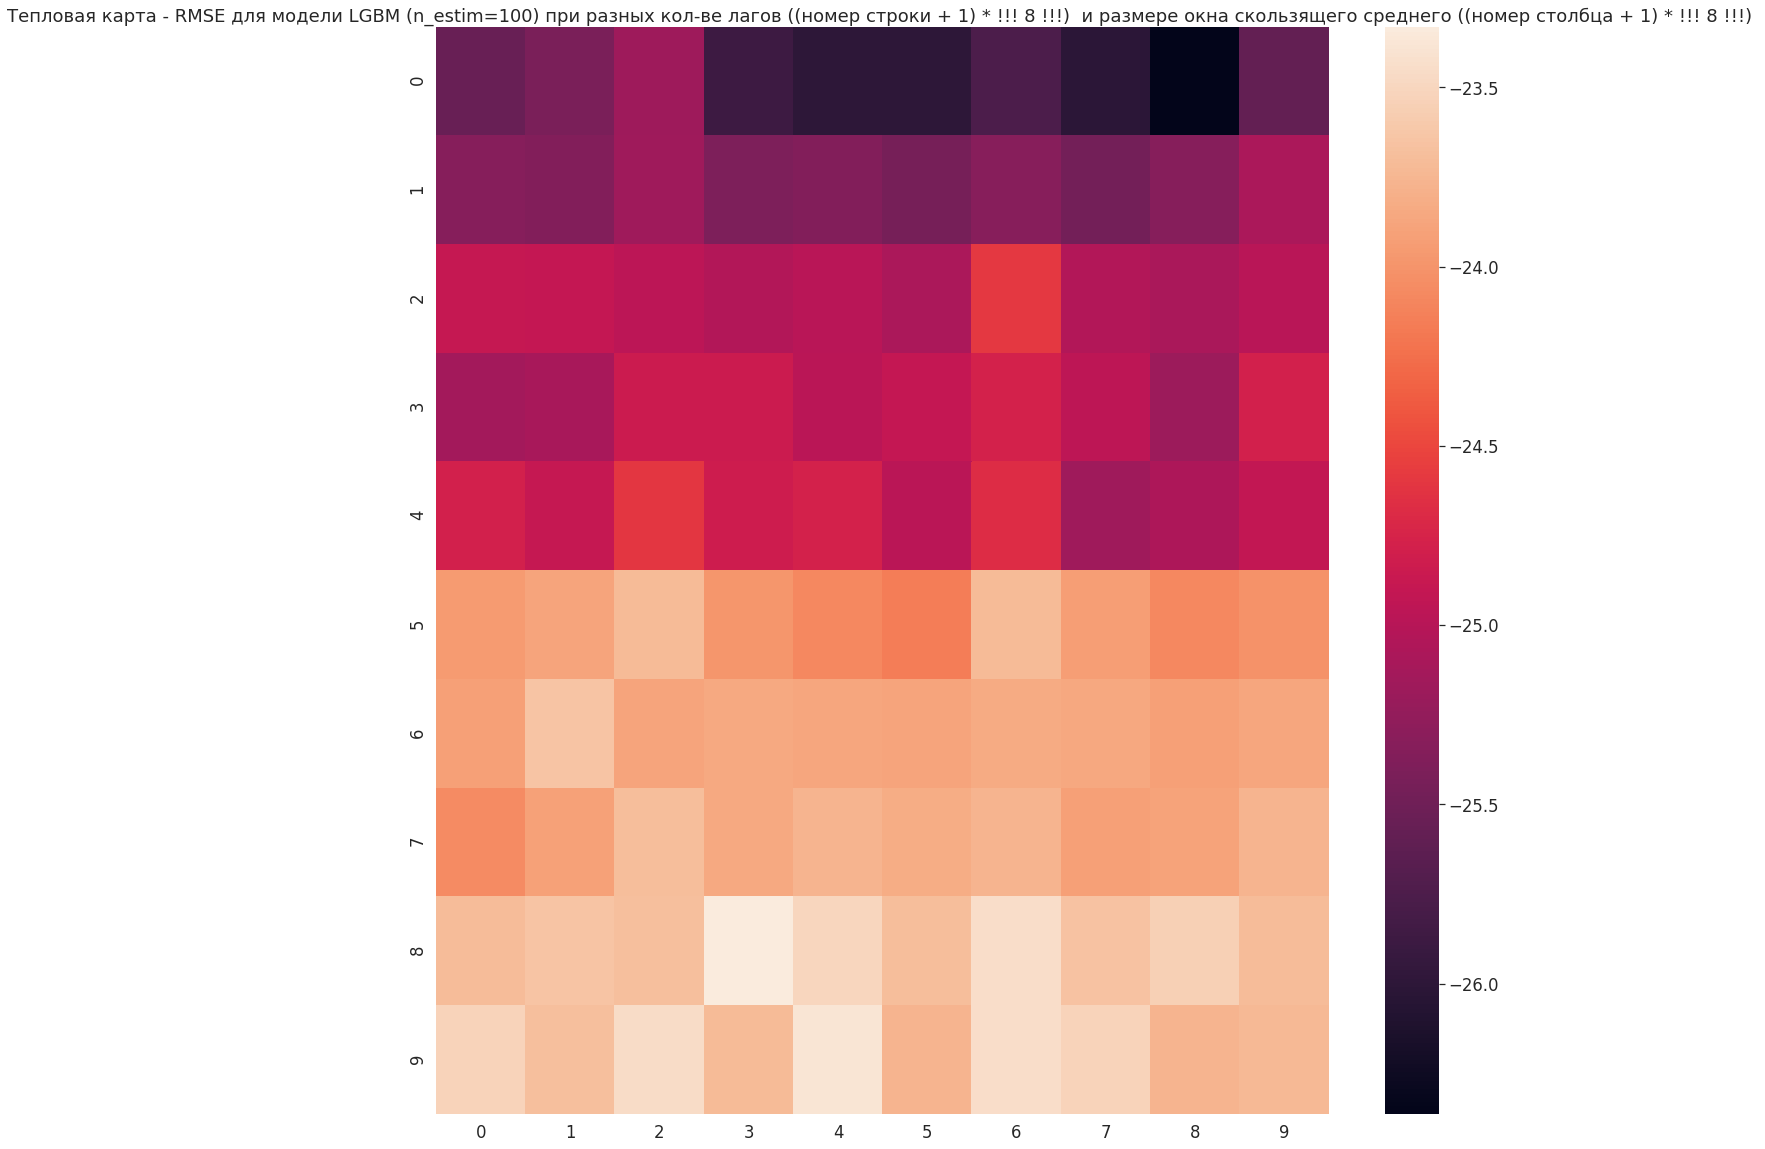

In [58]:
plt.figure(figsize=(20,20))
plt.title('Тепловая карта - RMSE для модели LGBM (n_estim=100) при разных кол-ве лагов ((номер строки + 1) * !!! 8 !!!)  и размере окна скользящего среднего ((номер столбца + 1) * !!! 8 !!!) ')
fig = sns.heatmap(df_ij_2)

Удивительно, качество модели продолжает улучшаться при увеличении числа лагов (максимально рассмотренное число лагов = 10 * 8 = 80).  
А вот размер окна похоже никак не влияет на rmse. Посмотрим на график среднего значения rmse по столбцам

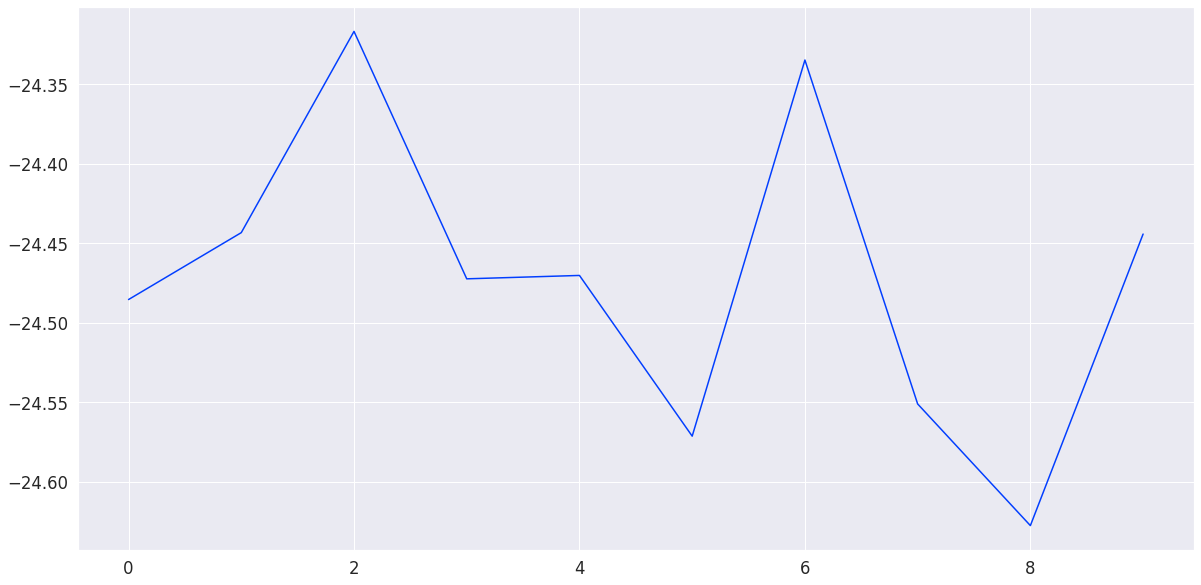

In [59]:
df_ij_2.mean().plot(figsize = (20,10))

График все еще напоминает шум. Появляется вопрос по rolling_mean. Влияет ли он вообще?   Давайте сравним модель со скользящим средним и без него (возьмем самый лучший размер окна = 2 * 8 = 16 (видно по графику выше) и лучшее число лагов = 10 * 8 - 80   - вычислено ранее в цикле)

Модель со скользящим средним:

In [60]:
param_grid_LGBM = {'max_depth': [14],
                  'min_data_in_leaf': [10],
                  'n_estimators' : [100],
                  'num_leaves': [70]}

model_LGBM_search = GridSearchCV(estimator = LGBMRegressor(random_state=42, n_jobs=-1), 
             param_grid= param_grid_LGBM, cv=3, verbose=1, n_jobs=-1, scoring = my_scorer)

df_1h_search = df_1h['num_orders'].to_frame()
make_features(df_1h_search, range(1, 65), 16)
df_1h_search.dropna(inplace=True)
        
X = df_1h_search.drop('num_orders', axis = 1)
y = df_1h_search['num_orders']
        
X_train, X_test, y_train, y_test =  train_test_split(X,y, shuffle=False, test_size=0.1, random_state = 42)
        
model_LGBM_search.fit(X_train, y_train)
        
rmse_with_rollmean = model_LGBM_search.best_score_
rmse_with_rollmean

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.3s finished


-23.73563490938837

Эта же модель без скользящего среднего

In [61]:
param_grid_LGBM = {'max_depth': [14],
                  'min_data_in_leaf': [10],
                  'n_estimators' : [100],
                  'num_leaves': [70]}

model_LGBM_search = GridSearchCV(estimator = LGBMRegressor(random_state=42, n_jobs=-1), 
             param_grid= param_grid_LGBM, cv=3, verbose=1, n_jobs=-1, scoring = my_scorer)

df_1h_search = df_1h['num_orders'].to_frame()
make_features(df_1h_search, range(1, 65), 16)
df_1h_search.dropna(inplace=True)

df_1h_search.drop('rolling_mean', axis = 1, inplace=True)

X = df_1h_search.drop('num_orders', axis = 1)
y = df_1h_search['num_orders']
        
X_train, X_test, y_train, y_test =  train_test_split(X,y, shuffle=False, test_size=0.1, random_state = 42)
        
model_LGBM_search.fit(X_train, y_train)
        
rmse_without_rollmean = model_LGBM_search.best_score_
rmse_without_rollmean

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.2s finished


-23.728737252239316

In [62]:
abs(rmse_without_rollmean) < abs(rmse_with_rollmean)

True

Без скользящего среднего модель стала более точной. Отличие в 4 знаке, но по крайней мере она точно не хуже. 

# 6. Выводы
1. Временной ряд имеет тренд - стабильное увеличение заказов на всем интервале времени.
2. В тренде выявлены повторяющиеся закономерности с периодом - 1 неделя => Признак, который поможет в обучении - dayofweek (описывает изменения внутри условного периода)
3. Сезонность ряда составляет 1 день => признак, который поможет в обучении час (описывает изменения внутри периода сезонности).
4. По графикам ACF и PACF отобраны лаги с высокой корреляцией с целевым признаком. Также была создана оконная функция - скользящее среднее.
5. Для обучения моделей были сгенерированы признаки:
6. Исследованы модели:  
  - среднее значение
  - предудыщее значение
  - линейная регрессия
  - случайный лес
  - LGBM
  - catboost

  Лучший результат на кроссвалидации показал случайный лес - RMSE = 25.01.  На тесте он показал RMSE = 44 
7. Исследовано влияние лагов и размера окна скользящего среднего:
  - последовательное добавление лагов к признакам стабильно ведет к увеличению качества моделей (исследовано для диапазона от 1 до 80 лагов, интервал лагов - 1час);
  - оконная функция не повлияла на качество модели (исследован размер окна от 1 до 80)  